## Technical Analysis Using Pandas

In this notebook, we will go over several examples of how to use pandas for technical analysis. We will be getting our price data from yfinance, which offers a free and reliable API for pulling financial data like stock price history, options, and fundamental financials.

First let's install all the necessary libraries:

<b>Yahoo Finance</b> (yfinance): As aforementioned, this library provides a simple API to download financial data, such as historical stock prices, option data, and other market data, directly from Yahoo Finance. We will use it to fetch stock price history for technical analysis.

<b>Pandas</b>: Pandas is a powerful data manipulation library that makes it easy to work with structured data like time series. We will use it to clean, organize, and analyze stock price data, as well as creating new price features (like SMA and EMA).

<b>Matplotlib</b>: Matplotlib is a powerful library for creating static visualizations, widely used in data science. In this notebook, we will use its pyplot submodule, which simplifies the process of creating and customizing plots.

<b>Numpy</b>: NumPy is a fundamental library for numerical computing in Python. It provides fast and efficient operations on arrays and matrices. We will use it to perform mathematical calculations, such as computing rolling averages and other statistical metrics required for technical analysis.

In [2]:
%pip install yfinance pandas matplotlib numpy

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



#### Plotting Simple Line Chart with SMAs

In the cell below, we will plot a simple line chart of TSLA stock with the 50-day and 200-day simple moving averages (SMA), which will track the average closing price of the last 50 and 200 days from each plot point. These SMAs are frequently used on daily stock charts to identify points of support or resistance. SMAs are also useful of filtering out the noise of stock charts and visualizing trends. The 50-day and 200-day SMAs are frequently used in tandem to identify trend changes as we will see later.

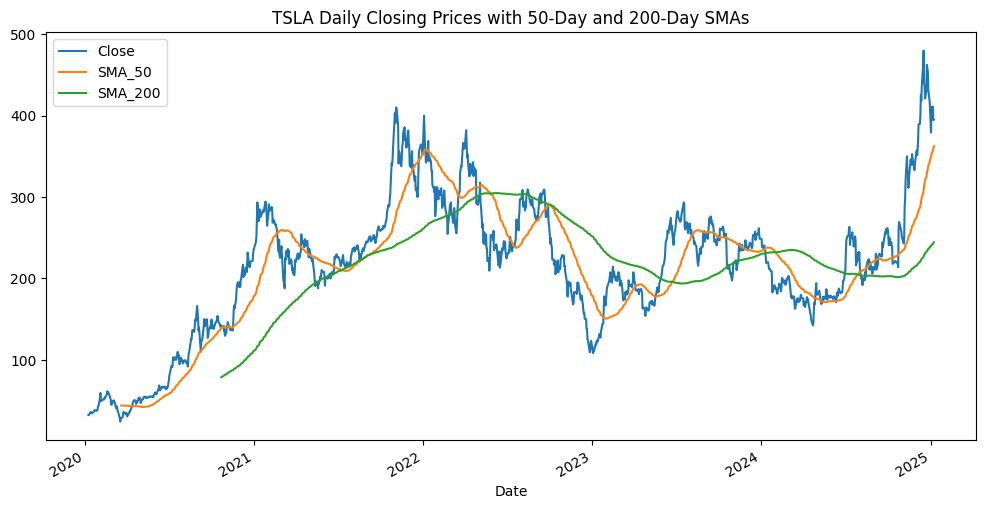

In [3]:
import matplotlib.pyplot as plt
import yfinance as yf

# Retrieve price history dataframe from yfinance
tesla_df = yf.Ticker("TSLA").history(period="5y")

# Calculate 50-day and 200-day SMAs
tesla_df['SMA_50'] = tesla_df['Close'].rolling(window=50).mean()
tesla_df['SMA_200'] = tesla_df['Close'].rolling(window=200).mean()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each line with a specified colors
# tesla_df['Close'].plot(ax=ax, color='black', label='Close')
# tesla_df['SMA_50'].plot(ax=ax, color='green', label='SMA 50')
# tesla_df['SMA_200'].plot(ax=ax, color='red', label='SMA 200')

# If color doesn't matter
tesla_df[['Close', 'SMA_50', 'SMA_200']].plot(ax=ax, title="TSLA Daily Closing Prices with 50-Day and 200-Day SMAs")

# Show plot
plt.show()

#### Plotting Golden and Death Cross 

As shown above, the 50-day SMA is much more sensitive to short term changes than the 200-day SMA. This is useful in identifying short term trend: when a shorter term SMA is above a longer term SMA, we can see the price generally trends upward, whereas when it is under the longer term SMA, it generally trends down. 

The points where these SMAs cross are frequently referred to as *Golden Cross* and *Death Cross*, respectively. In the cell below, we will create new columns in our dataframe to identify where these crosses happen and indicate them on the plot.

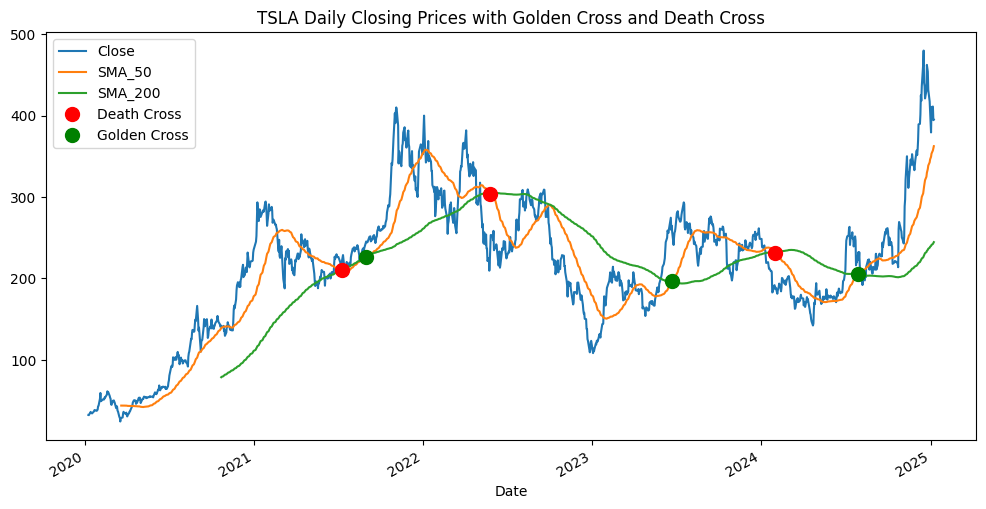

In [4]:
# Create new Signal column to help identify crosses

# Default signal
tesla_df['Signal'] = 0 
# Positive signal when SMA50 > SMA200
tesla_df.loc[tesla_df['SMA_50'] > tesla_df['SMA_200'], 'Signal'] = 1
# Negative signal when SMA50 < SMA200
tesla_df.loc[tesla_df['SMA_50'] < tesla_df['SMA_200'], 'Signal'] = -1

# Create a column to mark crossover points
# Crossover value of 2 == Golden Cross, signal indicates going from SMA50 < SMA200 to SMA50 > SMA200
# Crossover value of -2 == Death Cross, signal indicates going from SMA50 > SMA200 to SMA50 < SMA200
tesla_df['Crossover'] = tesla_df['Signal'].diff()

# Plot with Golden Cross and Death Cross
fig, ax = plt.subplots(figsize=(12, 6))
tesla_df[['Close', 'SMA_50', 'SMA_200']].plot(ax=ax, title="TSLA Daily Closing Prices with Golden Cross and Death Cross")

# Highlighting Golden Cross and Death Cross points
crosses = tesla_df[tesla_df['Crossover'] != 0]
for idx, row in crosses.iterrows():
    if row['Crossover'] == 2:
        plt.plot(idx, row['SMA_50'], 'go', markersize=10, label='Golden Cross' if 'Golden Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    elif row['Crossover'] == -2:
        plt.plot(idx, row['SMA_50'], 'ro', markersize=10, label='Death Cross' if 'Death Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    plt.legend()
    
plt.show()

#### Plotting VWAP

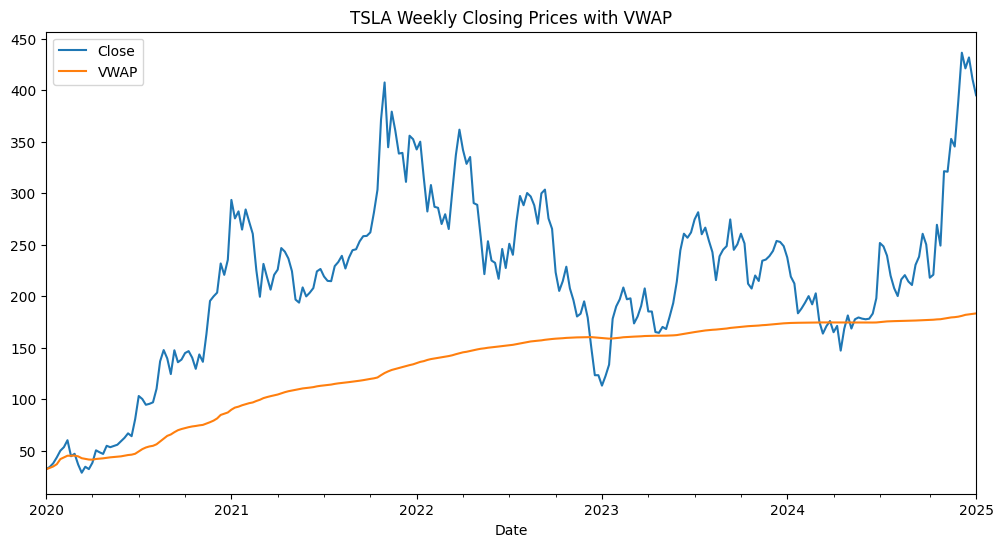

In [5]:
import numpy as np

# Get TSLA weekly price history for past 5 years
tesla_weekly = yf.Ticker("TSLA").history(interval="1wk", period="5y")

# Calculate the VWAP ( cumulative(volume*close) / cumulative(volume) )
tesla_weekly["VWAP"] = (np.cumsum(tesla_weekly['Volume'] *
                                    tesla_weekly['Close']) /
                          np.cumsum(tesla_weekly['Volume']))

# Visualize VWAP with Close Price
tesla_weekly[['Close', 'VWAP']].plot(figsize=(12, 6), title="TSLA Weekly Closing Prices with VWAP")

plt.show()

#### Using Matplotlib for Candlestick Charts

In [6]:
%pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


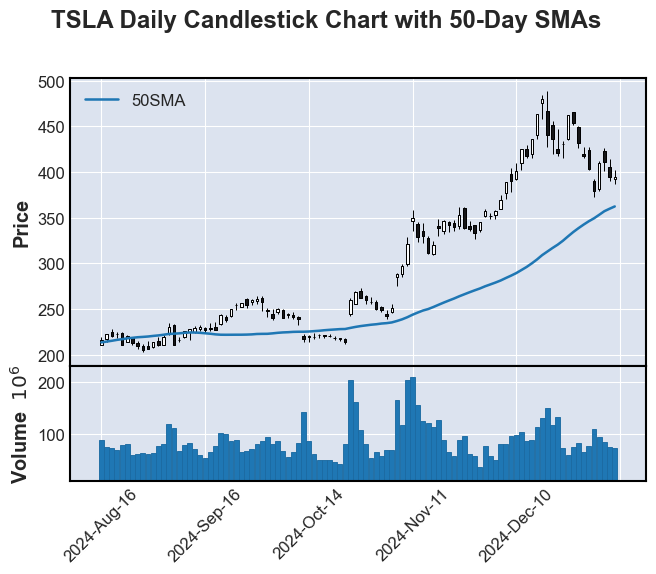

In [7]:
import mplfinance as mpf

sma50 = mpf.make_addplot(tesla_df['SMA_50'].tail(100), label='50SMA')
mpf.plot(tesla_df.tail(100), addplot=sma50, type="candle", volume=True, title='TSLA Daily Candlestick Chart with 50-Day SMAs')

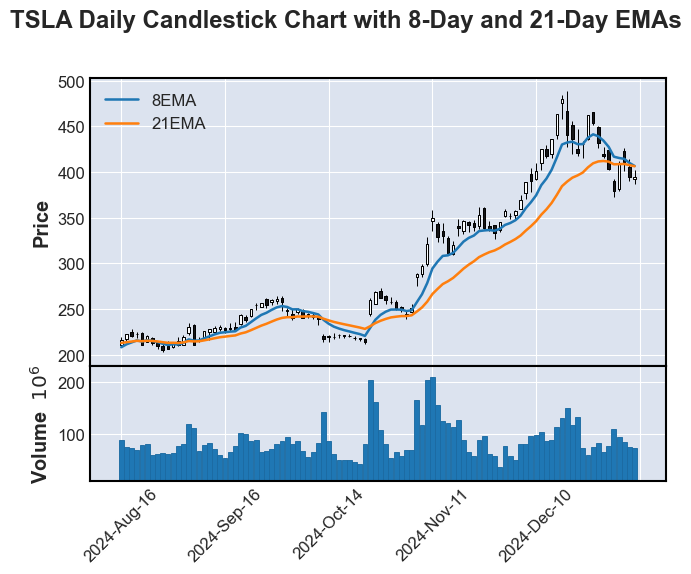

In [8]:
tesla_df['EMA_8'] = tesla_df['Close'].ewm(span=8).mean()
tesla_df['EMA_21'] = tesla_df['Close'].ewm(span=21).mean()

ema8 = mpf.make_addplot(tesla_df['EMA_8'].tail(100), label='8EMA')
ema21 = mpf.make_addplot(tesla_df['EMA_21'].tail(100), label='21EMA')

mpf.plot(tesla_df.tail(100), addplot=[ema8, ema21], type="candle", volume=True, title='TSLA Daily Candlestick Chart with 8-Day and 21-Day EMAs')

plt.show()

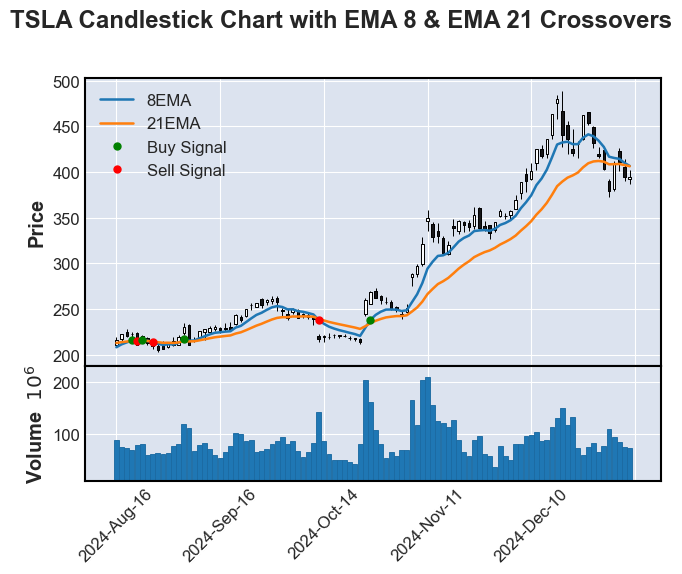

In [35]:
tesla_df['EMA_Signal'] = 0
tesla_df.loc[tesla_df['EMA_8'] > tesla_df['EMA_21'], 'EMA_Signal'] = 1 
tesla_df.loc[tesla_df['EMA_8'] < tesla_df['EMA_21'], 'EMA_Signal'] = -1

tesla_df['EMA_Crossover'] = tesla_df['EMA_Signal'].diff()

tesla_df_small = tesla_df.tail(100)

# Create the candlestick chart with EMAs
fig, ax = mpf.plot(
    tesla_df_small,
    type="candle",
    addplot=[ema8, ema21],
    volume=True,
    title="TSLA Candlestick Chart with EMA 8 & EMA 21 Crossovers",
    returnfig=True
)

# Plot buy and sell signals
ema_crosses = tesla_df_small[tesla_df_small['EMA_Crossover'] != 0]
for idx, row in ema_crosses.iterrows():
    # mplfinance uses positional indices for plotting, so we convert our Timestamp index into a positional index
    pos = tesla_df_small.index.get_loc(idx)
    if row['EMA_Crossover'] == 2:  # Buy signal
        ax[0].plot(pos, row['EMA_8'], 'go', markersize=5, label='Buy Signal' if 'Buy Signal' not in [text.get_text() for text in ax[0].get_legend().get_texts()] else "")
    elif row['EMA_Crossover'] == -2:  # Sell signal
        ax[0].plot(pos, row['EMA_8'], 'ro', markersize=5, label='Sell Signal' if 'Sell Signal' not in [text.get_text() for text in ax[0].get_legend().get_texts()] else "")
    ax[0].legend()

plt.show()

#### Using Plotly for Candlestick Charts
In the cells below, we show a simple example of how to plot the Tesla dataframe as a candlestick chart using Plotly, which is an interactive alternative to matplotlib. First, lets install plotly.

In [ ]:
%pip install plotly


Next, we will plot TSLA's price history (OHLC) using candlesticks along with the SMA50 and SMA100. The chart is interactive so you can zoom in, zoom out, pan, and hover over individual plot points to get detailed information about it. You also have the option to download the graph as a png, if you please.

In [22]:
import plotly.graph_objects as go

# Interactive candlestick chart with SMA50 and SMA200
fig = go.Figure(data=[go.Candlestick(x=tesla_df.index,
                open=tesla_df['Open'],
                high=tesla_df['High'],
                low=tesla_df['Low'],
                close=tesla_df['Close'],
                name="Candlesticks"),
                go.Scatter(x=tesla_df.index, 
                           y=tesla_df['SMA_50'], 
                           line=dict(color='green', width=1),
                           name="SMA 50"),
                go.Scatter(x=tesla_df.index, 
                           y=tesla_df['SMA_200'], 
                           line=dict(color='red', width=1),
                           name="SMA 200")])

fig.show()